# 자전거 수요 예측

In [30]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [3]:
df = pd.read_csv(r'D:\git_space\data\bike_sharing\train.csv')
print(df.shape)
df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
df['datetime'] = df.datetime.apply(pd.to_datetime)
df['year'] = df.datetime.apply(lambda x: x.year)
df['month'] = df.datetime.apply(lambda x: x.month)
df['day'] = df.datetime.apply(lambda x: x.day)
df['hour'] = df.datetime.apply(lambda x: x.hour)
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4


In [11]:
drop_columns = ['datetime', 'casual', 'registered']
df.drop(drop_columns, axis=1, inplace=True)

In [18]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print('RMSLE value: {}, RMSE value: {}, MAE value: {}'.format(rmsle_val, rmse_val, mae_val))

In [19]:
y_target = df['count']
X_features = df.drop(['count'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
evaluate_regr(y_test, pred)

RMSLE value: 1.1719320290982358, RMSE value: 139.9801336677261, MAE value: 105.53891389956419


### log 변환을 하지 않으면 cost function의 value가 너무 크다. 데이터 분포를 확인해보자

In [21]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred)

      real_count  predicted_count   diff
2236         834            189.0  645.0
2404         809            197.0  612.0
2877         948            362.0  586.0
155          731            147.0  584.0
985          890            322.0  568.0


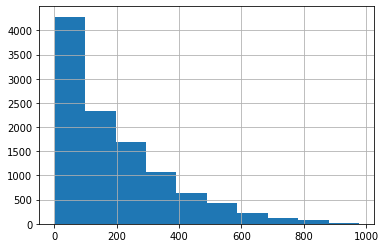

In [22]:
y_target.hist()

### label의 히스토그램을 확인해보니 데이터가 고르게 분포하지 않는다. 이를 log 변환하여 정규화 시키자

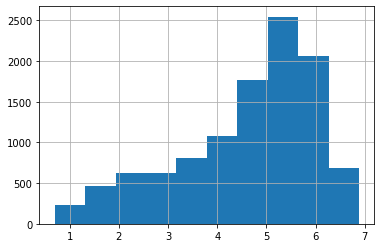

In [24]:
y_log = np.log1p(y_target)
y_log.hist()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_log, test_size=0.3)

lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)
evaluate_regr(y_test, pred)

RMSLE value: 0.229701185552617, RMSE value: 1.0086097669661467, MAE value: 0.7937602937597042


### RMSE와 MAE 값이 크게 감소하였다

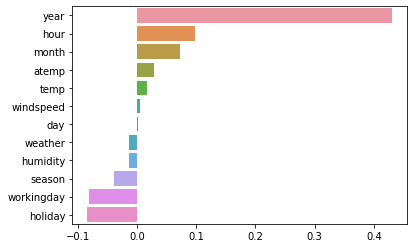

In [31]:
coef = pd.Series(lr.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### One Hot Encoding

In [37]:
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_log, test_size=0.3)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    evaluate_regr(y_test, pred)

lr = LinearRegression()
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.01)

for model in [lr, ridge, lasso]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False)

RMSLE value: 0.13445602019610142, RMSE value: 0.5729156630292671, MAE value: 0.429325878985418
RMSLE value: 0.13538495128344855, RMSE value: 0.5746534871671001, MAE value: 0.4327205880484428
RMSLE value: 0.14609016460819713, RMSE value: 0.6230560867615735, MAE value: 0.4816612634460773


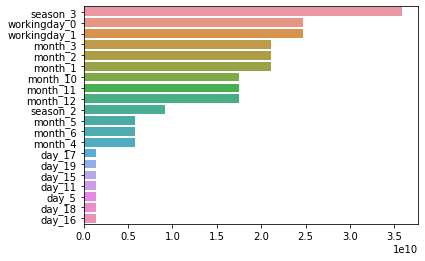

In [39]:
coef = pd.Series(lr.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

### 회귀 트리(Regression Tree)를 사용해보자

In [42]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf = RandomForestRegressor(n_estimators=500)
gbm = GradientBoostingRegressor(n_estimators=500)
xgb = XGBRegressor(n_estimators=500)
lgbm = LGBMRegressor(n_estimators=500)

for model in [rf, gbm, xgb, lgbm]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=False)

RMSLE value: 0.09013651040944992, RMSE value: 0.34817340681163444, MAE value: 0.234421676220332
RMSLE value: 0.08588510065143258, RMSE value: 0.33752961643082224, MAE value: 0.24191602219557834
[14:59:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE value: 0.08490146642721934, RMSE value: 0.33149255011453327, MAE value: 0.23736657328063115
RMSLE value: 0.08256208063467921, RMSE value: 0.31070220379295954, MAE value: 0.2124030932071263


### LGBM 회귀 트리가 제일 좋은 value를 보이고 있다